<a href="https://colab.research.google.com/github/DmitriyShalashov/LSTM-House-sales/blob/main/House_Sales_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
!pip install plotly
import plotly.express as px
import scipy
!pip install missingno
import missingno as msno
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
raw_sales=pd.read_csv("/content/drive/MyDrive/datasets/house-sales/raw_sales.csv")
ma_lpa=pd.read_csv("/content/drive/MyDrive/datasets/house-sales/ma_lga_12345.csv")
raw_sales[:5]

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [4]:
ma_lpa[:5]

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2


<Axes: >

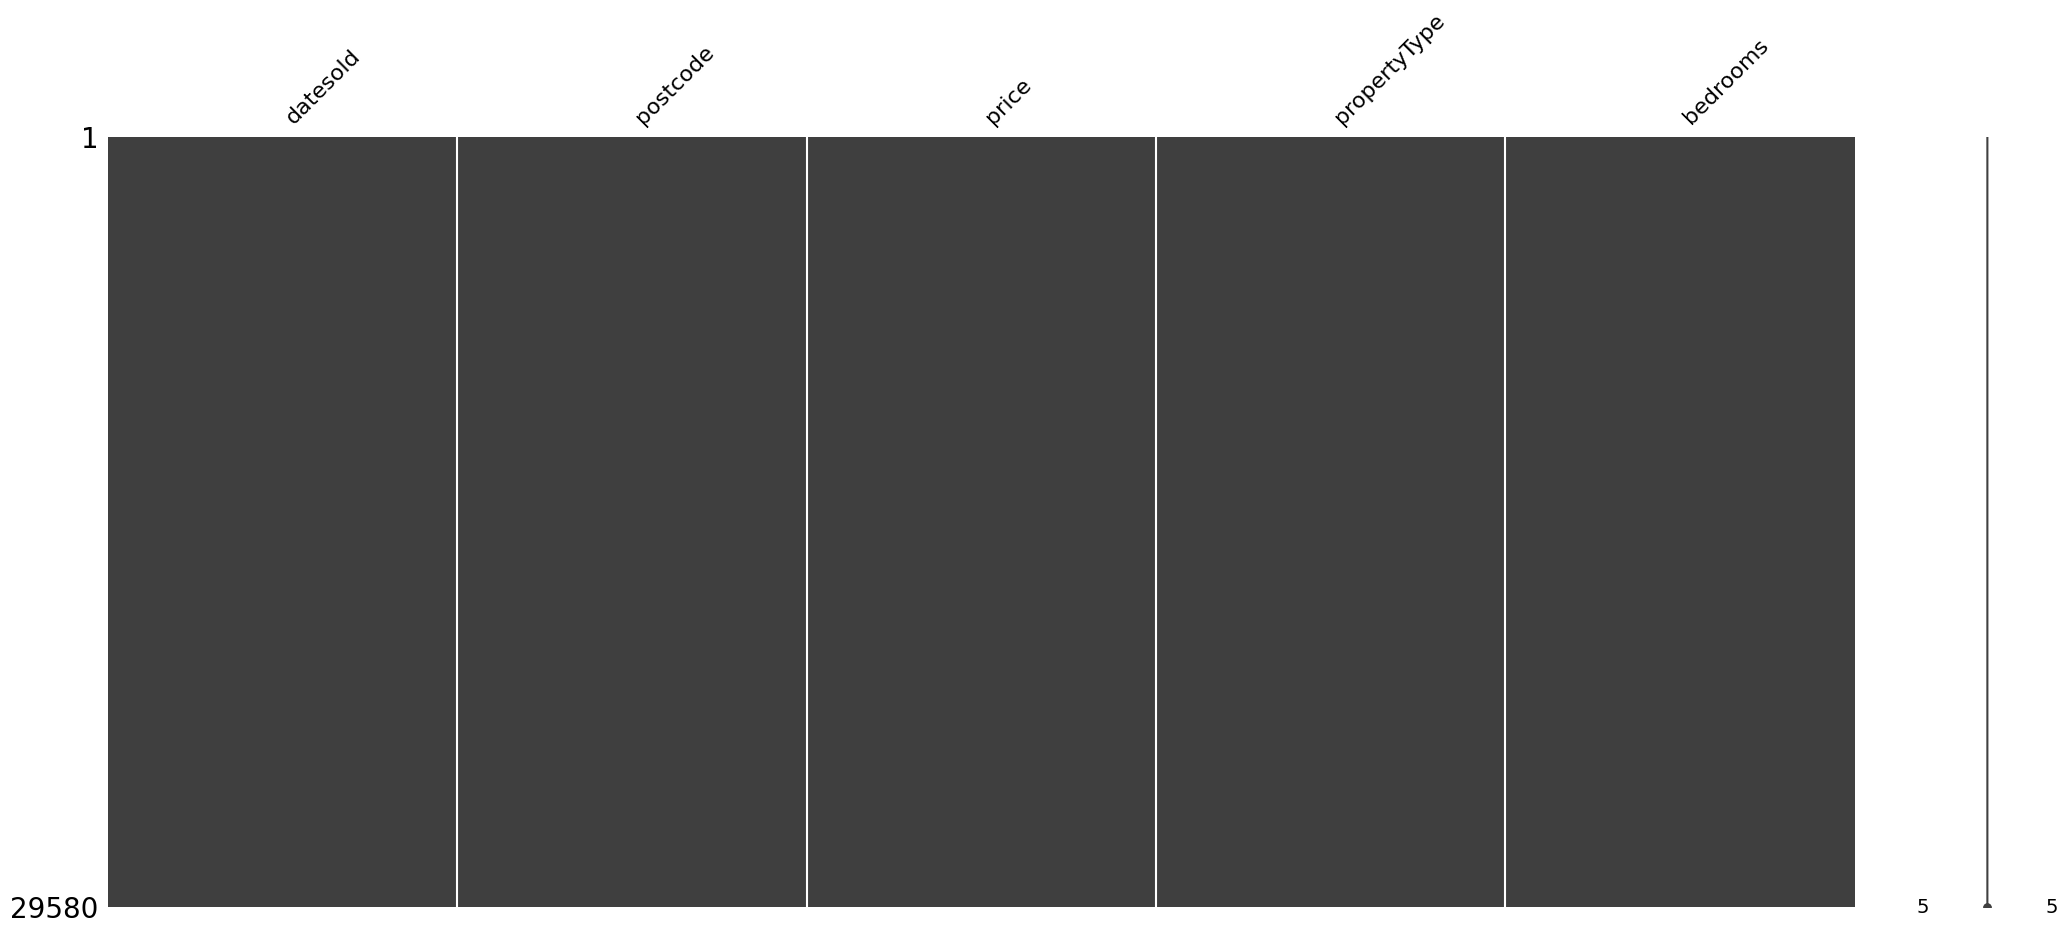

In [5]:
msno.matrix(raw_sales)

In [6]:
!pip install statsmodels
!pip install patsy


In [7]:
raw_sales['datesold']=pd.to_datetime(raw_sales['datesold'])
df=raw_sales[["price","datesold"]].groupby(["datesold"]).sum()
fig=px.line(df, y="price")
fig.show()

In [8]:
df['rolling_mean'] = df['price'].rolling(window=365).mean()
fig = go.Figure()
fig=px.line(x=df.index,y=df['rolling_mean'])

fig.show()

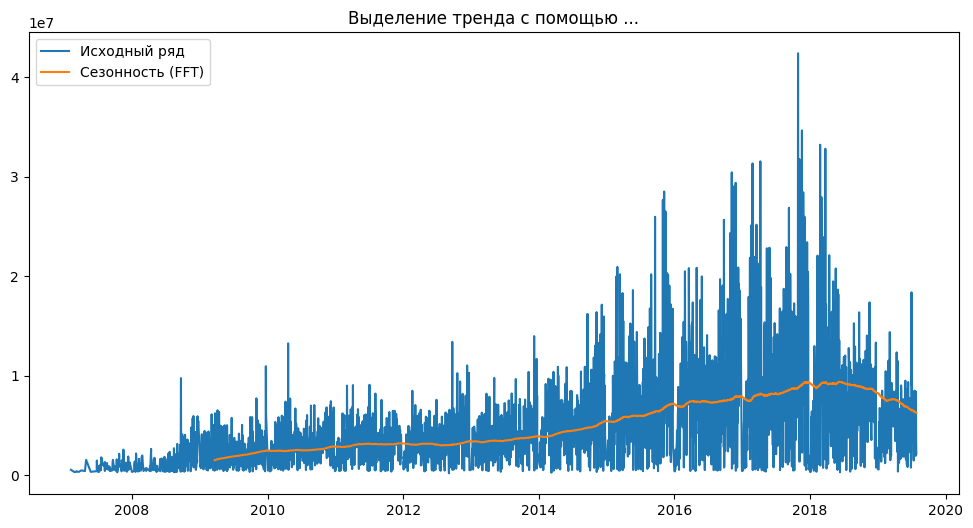

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df["price"], label='Исходный ряд')
plt.plot(df["price"].index, df["rolling_mean"], label='Сезонность (FFT)')
plt.legend()
plt.title('Выделение тренда с помощью ...')
plt.show()

In [10]:
from scipy.signal import savgol_filter
import plotly.graph_objects as go

df['savgol_trend'] = savgol_filter(df['price'], window_length=300, polyorder=2)

fig = go.Figure()
fig=px.line(df,y='savgol_trend')
fig.show()

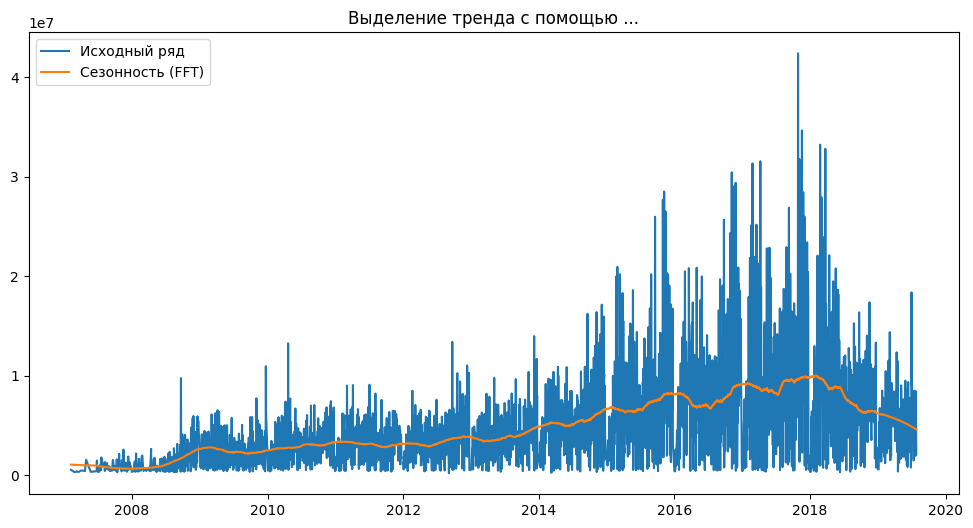

In [11]:
detrended_price=df["price"]-df["savgol_trend"]

plt.figure(figsize=(12, 6))
plt.plot(df["price"], label='Исходный ряд')
plt.plot(df["price"].index, df["savgol_trend"], label='Сезонность (FFT)')
plt.legend()
plt.title('Выделение тренда с помощью ...')
plt.show()

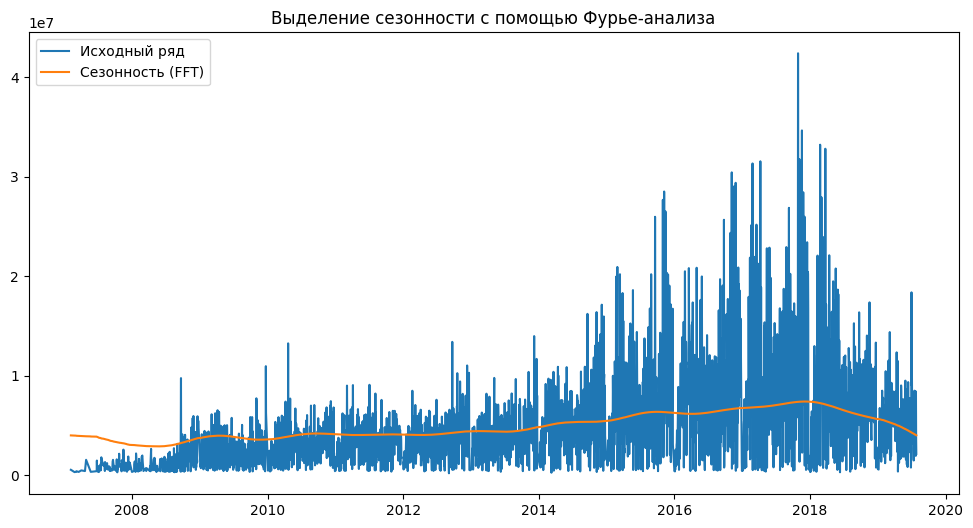

In [12]:
from scipy.fft import fft, ifft
fft_values = fft(df["price"].values)

fft_values[10:] = 0
seasonality = np.real(ifft(fft_values))

plt.figure(figsize=(12, 6))
plt.plot(df["price"], label='Исходный ряд')
plt.plot(df["price"].index, seasonality, label='Сезонность (FFT)')
plt.legend()
plt.title('Выделение сезонности с помощью Фурье-анализа')
plt.show()

In [13]:
residual=detrended_price-seasonality


fig=px.line(residual)
fig.show()

In [14]:
window_size = 20
smoothed_data = np.convolve(residual, np.ones(window_size)/window_size, mode='valid')

fig=px.line(smoothed_data)
fig.show()

In [15]:
from sklearn.ensemble import IsolationForest

data = residual.values.reshape(-1, 1)

model = IsolationForest(contamination=0.1)
model.fit(data)

outliers = model.predict(data)

filtered_data_IF = data[outliers == 1]

fig=px.line(filtered_data_IF)
fig.show()

In [16]:
Q1 = np.percentile(residual, 25)
Q3 = np.percentile(residual, 75)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаляем выбросы
filtered_data = residual[(residual >= lower_bound) & (residual <= upper_bound)]

fig=px.line(filtered_data)
fig.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Ряд стационарный")
    else:
        print("Ряд нестационарный")

check_stationarity(df["price"])

ADF Statistic: -3.913930159643228
p-value: 0.001934687315487266
Critical Values: {'1%': -3.4321902774899167, '5%': -2.8623531309983417, '10%': -2.5672028430631353}
Ряд стационарный


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



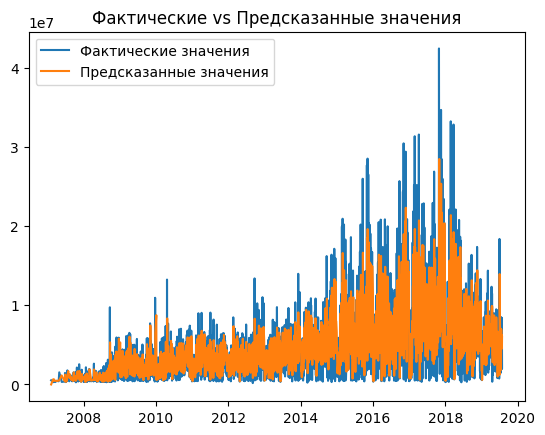

In [18]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df["price"], order=(1, 2, 1))
arima_fit = arima_model.fit()
fitted_values = arima_fit.fittedvalues
fitted_values.index=df.index

plt.plot(df["price"], label="Фактические значения")
plt.plot(fitted_values, label="Предсказанные значения")
plt.legend()
plt.title("Фактические vs Предсказанные значения")
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



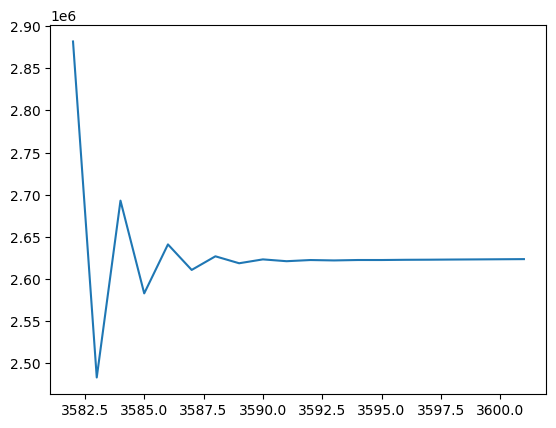

In [19]:
predicts=arima_fit.forecast(steps=20)
plt.plot(predicts, label="Прогноз")
plt.show()

In [20]:
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)


In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler_X=MinMaxScaler()
scaler_y=MinMaxScaler()
sequence_length=10

X,y=create_sequences(filtered_data,sequence_length)
X=scaler_X.fit_transform(X)
y=scaler_y.fit_transform(y.reshape(-1,1))

<ipython-input-20-2da4dbd71af5>:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input,BatchNormalization,Dropout

In [25]:
model = Sequential()
model.add(Input((sequence_length, 1)))
model.add(BatchNormalization())
model.add(LSTM(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(clipnorm=5), loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [26]:
model.fit(X, y, batch_size=32, epochs=250, verbose=1)

Epoch 1/250
104/104 ━━━━━━━━━━━━━━━━━━━━ 67s 593ms/step - loss: 0.0705 - root_mean_squared_error: 0.2580
Epoch 2/250
104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 560ms/step - loss: 0.0309 - root_mean_squared_error: 0.1755
Epoch 3/250
104/104 ━━━━━━━━━━━━━━━━━━━━ 84s 580ms/step - loss: 0.0297 - root_mean_squared_error: 0.1722
Epoch 4/250
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 561ms/step - loss: 0.0288 - root_mean_squared_error: 0.1697
Epoch 5/250
104/104 ━━━━━━━━━━━━━━━━━━━━ 87s 615ms/step - loss: 0.0292 - root_mean_squared_error: 0.1708
Epoch 6/250
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 617ms/step - loss: 0.0282 - root_mean_squared_error: 0.1678
Epoch 7/250
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 568ms/step - loss: 0.0275 - root_mean_squared_error: 0.1657
Epoch 8/250
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 570ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690
Epoch 9/250
104/104 ━━━━━━━━━━━━━━━━━━━━ 58s 559ms/step - loss: 0.0273 - root_mean_squared_error: 0.1650
Epoch 10/250
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 556ms/ste

In [28]:
predicts=model.predict(X)

104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step


In [27]:
model.save("my_model.keras")

250 эпох 1 слой LSTM + 3 полносвязных слоя

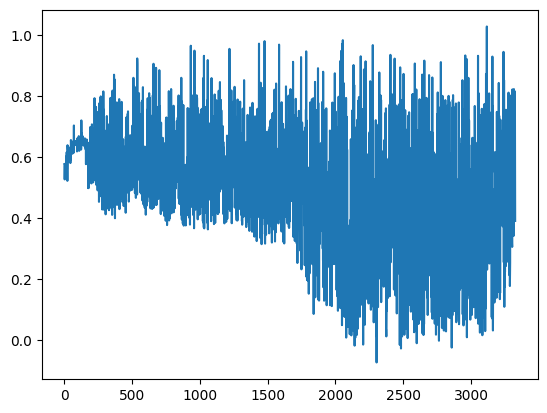

In [29]:
plt.plot(predicts)
plt.show()

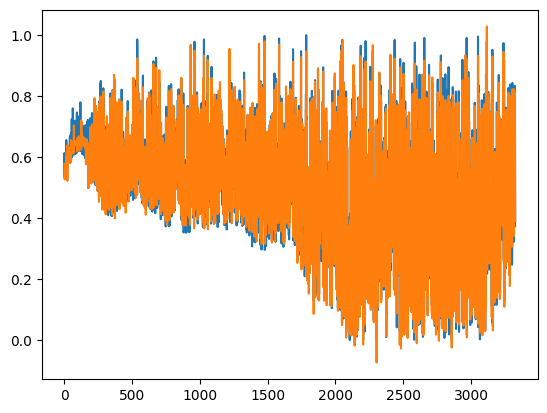

In [30]:
plt.plot(y)
plt.plot(predicts)

plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step


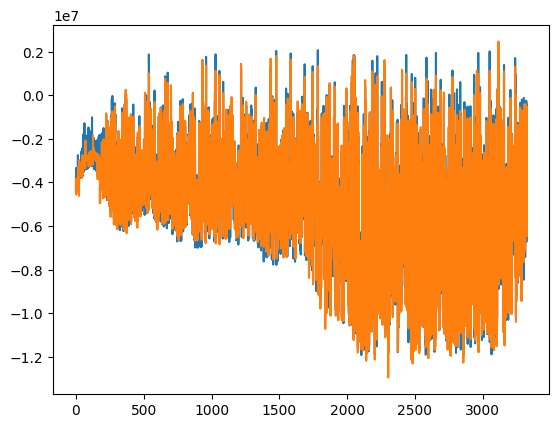

In [31]:
y_true=scaler_y.inverse_transform(y)
y_pred=scaler_y.inverse_transform(model.predict(X))

plt.plot(y_true)
plt.plot(y_pred)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms

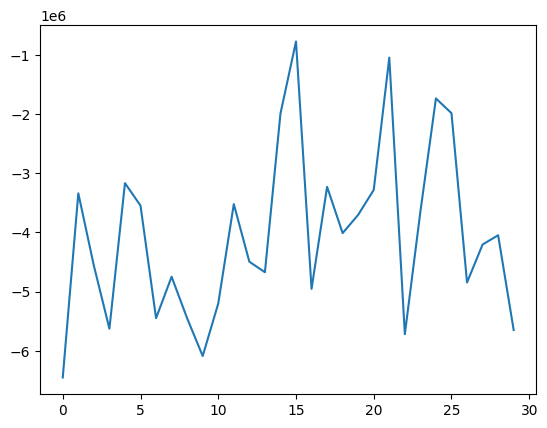

In [47]:
prev=np.array([X[-1]])
forecasts=[]
for _ in range(30):
  predict=model.predict(prev)
  prev=np.roll(prev,-1)
  prev[0,-1]=predict[0,0]
  forecasts.append(predict[0,0])

plt.plot(scaler_y.inverse_transform(np.array(forecasts).reshape(-1,1)))
plt.show()
